# Schelling Segregation

## Conceptual description
The basic idea of Schelling's seggregation model is quite straight forward. Imagine we have agents organized on a grid. Agents are either red or blue. Agents prefer to be in an environment with agents of the same color, but they are quite tolerant. If the fraction of neighbors of a different color is higher than this tolerance threshold, the agent moves to another free grid cell. At what level of tolerance does segregation occur? 

Given this basic description, the model is composed of a grid, with one agent per grid cell. This grid is not completely filled because we need to have free space to where an agent can move. Each agent has a tolerance level, and checks when asked if the fraction of neighbors that is of the different type is higher than this tolerance level. 

## Implementing a first version of the model

### Assignment

1. What classes do you need for this model? And what are the key attributes for each of these classes?



**answer:**

Agent class met hoe elke agent werkt, 
een class voor rood en een class voor blauw
een class wat voor opties een agent heeft, dus blijven of gaan
 Model class
 


## Agent activation
A key issue with the Schelling model, and a key way in which this model is different from the various versions of the Axelrod model is that a step by a given agent can change the local environment. Imagine that a given agent checks its neighborhood, decided that the number of neighbors of a different color is higher than its threshold, and thus decides to move to an empty spot. This move changes the neighborhood the agent is leaving. It also changes the neighborhood the agent is moving to. Depending on the order in which agents are activated (i.e. the `step` method is called) different dynamic patterns can occur.

There are various archetypical agent activation patterns. In the axelrod model, we simply activated all agents in the same order because activation order did not matter in any of the versions of the model. However, in for example the Schelling model, we can't do this because activation order will matter. A standard solution for this is to use **random activation**. That is, we shuffle the agents every model step and activate them in this shuffeled order. In Mesa, this is readily available via `model.agents.shuffle_do` which is a convenient short-hand for `model.agents.shuffle().do()`. An other common option is to seperate the intentions of the agents from their implementation. This is sometimes also called **staged activation**. The idea is that first all agents based on their local information decide what action they are going to take without updating any of their public attributes. Next, all agents implement their action and thus update their public attributes. In Mesa, this is done by having two methods on the agent (e.g., `determine_action`, `implement_action`). Next, we can easily implement staged activation by doing `model.agents.do("determine_action").do("implement_action")`. Note that I am assuming here that there is no path dependence in either `determine_action` or `implement_action` because if there was, we would have to use `shuffle_do`. Staged activation can be used for simulating true parallel actions, but it can also be used for more complex interaction patterns were agents have multiple methods that contain part of their overal activation. A last commonly encountered pattern is where we have multiple different classes of agents, and we want to activate all agents of a given class. This is sometimes also called **random activation by type**. Again this is easy to do in mesa:

```python
agent_types = self.random.shuffle(Agent.__subclasses__)
for agent_type in agent_types:
    self.agent_by_type[agent_type].shuffle_do('step')

```

Here, we have 2 levels of randomness. First, we shuffle the order of the agent types (using the `Agent.__subclasses__` trick we saw with Axelrod, but you could also explicate the types here: `self.random.shuffle([Wolf, Sheep, Grass])`). Next for each class of agents, we get the associated `AgentSet` and use `shuffle_do` for random activation. 



## Assignment 1

Below, I have given the outline of the model, we are going to implement this now. First, implement the ``__init__`` of the model. It is indicated below with the `...`. A hint regarding attributes can be found in the docstring. The code is very similar to the initialization used for the spatial version of the Axelrod model. After the code block, there is some test code to help you check if your code is working.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mesa import Model, Agent
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from mesa.experimental.cell_space import CellAgent, OrthogonalMooreGrid

from enum import Enum

class Color(Enum):
    RED = 1 # minority color
    BLUE = 2 # majority color


class Schelling(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of width
    density : float
            fraction of grid cells occupied
    minority_fraction : float
            fraction of agent of minority color
    tolerance_threshold : int
    
    Attributes
    ----------
    height : int
    width : int
    density : float
    minority_fraction : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, density=0.8, minority_fraction=0.2,
                 tolerance_threshold=4, seed=None):
        super().__init__(seed=seed)
        
        self.height = height
        self.width = width
        self.density = density
        self.minority_fraction = minority_fraction
        self.tolerance_threshold = tolerance_threshold

        self.grid = OrthogonalMooreGrid((width, height), torus=True, capacity=1, random=self.random)

        for cell in self.grid.all_cells:
            if self.random.random()<self.density:
                if self.random.random()<self.minority_fraction:
                    agent_color=Color.RED
                else:
                    agent_color=Color.BLUE
                agent = SchellingAgent(self, agent_color, tolerance_threshold)
                agent.cell = cell






    def step(self):
        """
        Run one step of the model.
        """
        self.agents.shuffle_do("step")


class SchellingAgent(CellAgent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : int
    
    """

    def __init__(self, model, color, tolerance_threshold):
        super().__init__(model) #pos, 
        self.color = color
        self.tolerance_threshold = tolerance_threshold

    def step(self):
        raise NotImplementedError


C:\Users\Tijn\AppData\Local\Temp\ipykernel_31256\293664993.py:9: DeprecationWarning: you are importing from mesa.experimental.cell_space, all cell spaces have been moved to mesa.discrete_space
  from mesa.experimental.cell_space import CellAgent, OrthogonalMooreGrid



To test the implementation, we can visualize the grid. To do this, we are creating a numpy array with zeros of the same width and height as the model grid. Next, we iterate over the grid and fill in this empty array. We use a value of 3 for an empty cell, and the color number from the `Color` enum class. 

We can easily visualize the filled in numpy array using matplotlib (e.g. matshow) or seaborn's heatmap. To make the figure a bit nicer, I use a few tricks. First, I am getting a color map from seaborn. This color map is generated by the [colorbrewer](https://colorbrewer2.org/) website. As you can see on this website, the `Set1` colormap has red as 1, blue as 2, and 3 as green. This matches perfectly with the numbers used in filling in the numpy array (and why we used 3 for the empty cells). Second, I like to have a nice equally spaced figure, which you can do by setting the aspect of the axes to equal. 



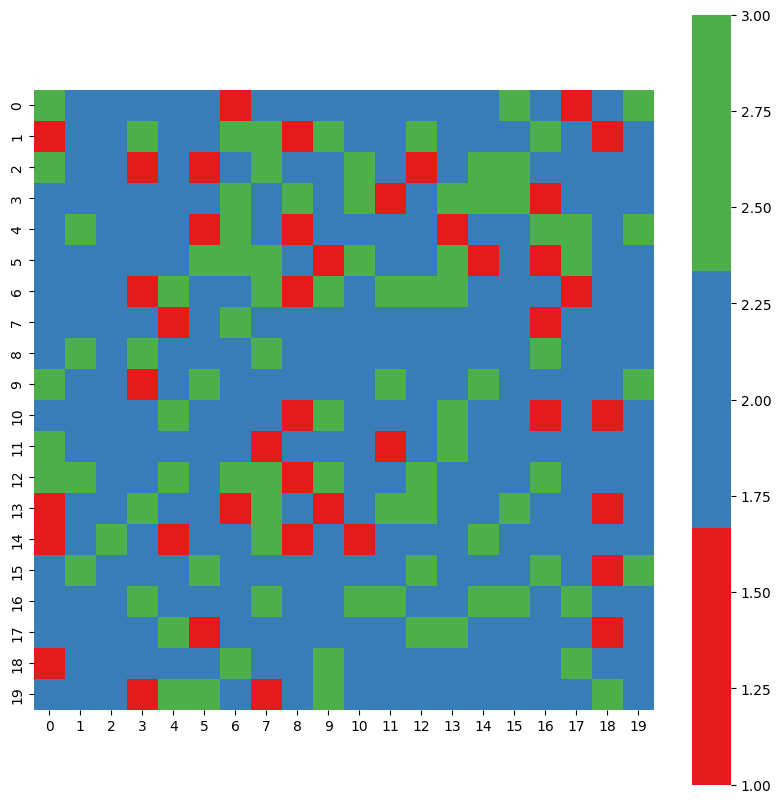

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model = Schelling()


def plot_model(model, ax, colors):
    grid = np.zeros((model.height, model.width))

    for cell in model.grid.all_cells:
        i, j = cell.coordinate
        value = 3
        if not cell.is_empty:
            value = cell.agents[0].color.value
        grid[i, j] = value
    sns.heatmap(grid, ax=ax, cmap=colors)

fig, ax = plt.subplots(figsize=(10, 10))
colors = sns.color_palette('Set1', 3)
ax.set_aspect('equal')

plot_model(model, ax, colors)

plt.show()

## Assignment 2
The next step is to implement the logic in the step method of the agent. This is straight forward, we iterate over our neighbors. If our neighbor is of a different color, we increment a counter. After having checked our entire neighborhood, the agent compares this counter with its tolerance threshold. If the number of neighbors of a different color is higher than the threshold, the agent will move. For now, we will use the `select_random_empty_cell` method on the grid for this. 


Go ahead and implement the model.

Test code is provided below.

In [3]:
class SchellingAgent(CellAgent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : int
    
    """

    def __init__(self, model, color, tolerance_threshold):
        super().__init__(model) #pos, 
        self.color = color
        self.tolerance_threshold = tolerance_threshold

    def step(self):
        different=0
        for neighbor in self.cell.neighborhood.agents:
            if neighbor.color!=self.color:
                different+=1
        if self.tolerance_threshold<different:
             new_cell=self.model.grid.select_random_empty_cell()
             self.cell=new_cell


In [4]:
from mesa.visualization import Slider
from mesa.visualization.components import AgentPortrayalStyle

def agent_portrayal(agent):
    if agent.color == Color.RED:
        color = 'tab:red'
    elif agent.color == Color.BLUE:
        color = 'tab:blue'
    return AgentPortrayalStyle(color=color, size=150)


model_params = {
    "density": Slider("density", 0.8, 0.01, 0.99, 0.01),
    "minority_fraction": Slider("minority fraction", 0.2, 0.01, 0.49, 0.01),
    "tolerance_threshold": Slider("tolerance treshold", 4, 1, 7, 1), 
    "width": 20,
    "height": 20,
}


c:\Users\Tijn\anaconda3.1\envs\mesa-env\Lib\site-packages\solara\validate_hooks.py:122: UserWarning: c:\Users\Tijn\anaconda3.1\envs\mesa-env\Lib\site-packages\mesa\visualization\solara_viz.py:399: ComponentsView: `use_state` found despite early return on line 376
To suppress this check, replace the line with:
    current_tab_index, set_current_tab_index = solara.use_state(0)  # noqa: SH101

Make sure you understand the consequences of this, by reading about the rules of hooks at:
    https://solara.dev/documentation/advanced/understanding/rules-of-hooks

  warnings.warn(str(e))


Cannot show ipywidgets in text

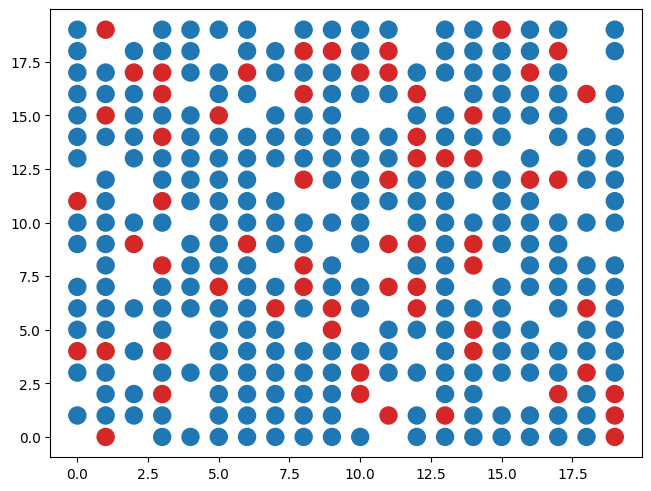

In [5]:
from mesa.visualization import SolaraViz, SpaceRenderer

renderer = SpaceRenderer(model)
renderer.draw_agents(agent_portrayal=agent_portrayal)

page = SolaraViz(
    Schelling(),
    renderer,
    model_params=model_params
)
# This is required to render the visualization in the Jupyter notebook
page

We now have a basis version of Schelling seggregation working. We can play around with this model and already learn quite a bit. However, we can also expand the model a bit more.

## Assignment 3
We now have a working model. But we have so far relied only on visual inspection of the model. If we want to explore different tolerance levels, we need some useful statistics from the model as well. Making sense only of the grid is rather hard if we start running this model a few hundred times for different random seeds, different tolerance levels, and different neighborhood rules. A statistic that is easy to check is keeping track of how many agents are happy with their position. That is, they did not want to move to a new location. 

Implementing this requires a few changes:

* Agents need a happy attribute. This is set to True if the agent did not move. It is set to False otherwise.
* The model needs a data collector. This collector is called at each step of the model after all agents have moved and keeps track of the total number of happy agents.

Go ahead and update both the agent and the model.

In [ ]:
def count_happy(model):
    ...
    

class Schelling(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of width
    density : float
            fraction of grid cells occupied
    minority_fraction : float
            fraction of agent of minority color
    tolerance_threshold : int
    
    Attributes
    ----------
    height : int
    width : int
    density : float
    minority_fraction : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, density=0.8, minority_fraction=0.2,
                 tolerance_threshold=4, seed=None):
        super().__init__(seed=seed)
        
        
        self.height = height
        self.width = width
        self.density = density
        self.minority_fraction = minority_fraction

        # self.schedule = RandomActivation(self)
        self.grid = OrthogonalMooreGrid((width, height), torus=True, capacity=1, random=self.random)
        self.datacollector = DataCollector(model_reporters={'happy':count_happy})

        # Set up agents
        # We iterate over all cells in the grid
        for cell in self.grid.all_cells:
            if self.random.random() < self.density:
                agent_color = Color.RED if self.random.random() < self.minority_fraction else Color.BLUE
                agent = SchellingAgent(self, agent_color, tolerance_threshold)
                agent.cell = cell
        self.datacollector.collect(self)

    def step(self):
        """
        Run one step of the model.
        """
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)


class SchellingAgent(CellAgent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : int
    
    """

    def __init__(self, model, color, tolerance_threshold):
        super().__init__(model) #pos, 
        self.color = color
        self.tolerance_threshold = tolerance_threshold
        self.happy = False

    def step(self):
        ...


In [ ]:
from mesa.visualization import SolaraViz, SpaceRenderer

renderer = SpaceRenderer(model)
renderer.draw_agents(agent_portrayal=agent_portrayal)

page = SolaraViz(
    Schelling(),
    renderer,
    model_params=model_params
)
# This is required to render the visualization in the Jupyter notebook
page

## Assignment 4
We used the ``select_random_empty_cell`` method to fiind an empty cell to move the agent to. However, this method simply returns a random empty cell. We can make this a bit smarter by checking each free cell to see if moving there makes sense. That is, would the new neighborhood meet our preferences with respect to the different types of neighbors?

Below I have given the basic structure of this refined agent class. You have to fill in the `...` parts. Some more useful methods and attributes you might need are

* *grid.all_cells*; contains the collection of all grid cells
* *grid.empties* collection of all empty cells
* *cell.is_empty* a boolean indicating if a cell is empty or not
* moving can be done by assigning a new value to `agent.cell`

Note that I have moved the checking of the threshold to its own seperate method which takes as input a position. In this way we can use the exact same code for checking whether an agent wants to move (we pass `self.cell`) or whether an empty cell meets the threshold (we pass an entry from `self.model.grid.empties`)

In [ ]:
class SchellingAgent(CellAgent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : float
    
    """

    def __init__(self, model, color, tolerance_threshold):
        super().__init__(model)  
        self.color = color
        self.tolerance_threshold = tolerance_threshold
        self.happy = True

    def meets_threshold(self, cell):
        '''check if a given cell meets the tolerance threshold
        
        Returns
        -------
        bool
        
        '''
        different = 0
        for neighbor in cell.neighborhood.agents:
            if neighbor.color != self.color:
                different += 1
        
        return different <= self.tolerance_threshold
       
    def move_to_empty(self):
        '''move to an empty spot in the grid if the empty spot meets the tolerance threshold'''
        ...
            
    def step(self):
        '''execute one step of the agent'''
        ...

In [ ]:
page = SolaraViz(
    Schelling(),
    components=[make_space_matplotlib(agent_portrayal=agent_portrayal), make_plot_measure("happy")],
    model_params=model_params
)
# This is required to render the visualization in the Jupyter notebook
page

## Assignment 5
So far, we have run the model for the default values of the parameters `density`, `minority_fraction`, and `tolerance_threshold`. It is quite common in Agent Based Modelling to perform a parameter sweep where one runs the model over a range of parameterizations and analyse the results.

MESA support this with a `batch_run` function. See the [MESA tutorial](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html#batch-run) for details. In short, the `batch_run` function allows you to specify a set of values (fixed for parameters you don't want to vary and iterables for the parameters you do want to vary), the number of iterations/replications for each run and the number of steps to run the model for. At the end of each run, it automatically collects all statistics specified in the `self.datacollector` attribute of your model.

The `batch_run` function assumes that a `self.running` attribute is available on the model. This is used to indicate that the model has reached a stable equilibrium and will not change in any subsequent steps. If running is True, the model will still change. If running is False, the model has reached an equilibrium.

1. Let's update our model with this running attribute. What conditions must hold for the model to have reached equilibirum?

**Answer: The condition that must hold for the model to have reached equilibirum, is that all agents in the model are happy.**

2. Implement this condition and the running attribute. 
*Hint:* you can get the number of agents in the model via `len(self.agents)`

3. Perform a batch run with the following settings. Visualize some results:
    * height and width fixed at 20
    * density varies from 0.8 to 0.9 with 0.025 increments
    * minority_fraction varies from 0.2 to 0.4 with 0.1 increments
    * tolerance_threshold varies from 2 to 4 with increment of 1
    * 5 replications
    * 50 steps

In [ ]:
class Schelling(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of width
    density : float
            fraction of grid cells occupied
    minority_fraction : float
            fraction of agent of minority color
    tolerance_threshold : int
    
    Attributes
    ----------
    height : int
    width : int
    density : float
    minority_fraction : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, density=0.8, minority_fraction=0.2,
                 tolerance_threshold=4, seed=None):
        super().__init__(seed=seed)
        
        self.height = height
        self.width = width
        self.density = density
        self.minority_fraction = minority_fraction

        # self.schedule = RandomActivation(self)
        self.grid = OrthogonalMooreGrid((width, height), torus=True, capacity=1, random=self.random)
        self.datacollector = DataCollector(model_reporters={'happy':count_happy})

        # Set up agents
        # We iterate over all cells in the grid
        for cell in self.grid.all_cells:
            if self.random.random() < self.density:
                agent_color = Color.RED if self.random.random() < self.minority_fraction else Color.BLUE
                agent = SchellingAgent(self, agent_color, tolerance_threshold)
                agent.cell = cell
        self.datacollector.collect(self)

    def step(self):
        """
        Run one step of the model.
        """
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)
        
        ...

In [ ]:
from mesa.batchrunner import batch_run

params = {'width': 20, 'height': 20,
          'density': [0.8, 0.825, 0.85, 0.875, 0.9],
          'minority_fraction': [0.2, 0.3, 0.4],
          'tolerance_threshold': [2, 3, 4]}

results = batch_run(Schelling, params, iterations=5, max_steps=50)

In [ ]:
results_df = pd.DataFrame(results)
results_df.head(10)

In [ ]:

fig, ax = plt.subplots(figsize=(10,10.5))
points = ax.scatter(results_df.minority_fraction, results_df.density, c=results_df.happy,
          cmap='viridis')
ax.set_xlabel('minority fraction')
ax.set_ylabel('density')
fig.colorbar(points, label="# happy")
plt.show()